# Differentiable Histograms

One of the most common data structures in HEP is the **histogram**. It is a very powerful data reduction and density estimation technique, and ubiquitous in the field.

A histogram can be thought of as a set of intervals on a 1D domain (bins), and a set of counts for each interval (yields).

We want to take the gradient of the yields with respect to the parameters that control the data (φ). But this is ill-defined -- histograms are discrete!

To illustrate this further: gradients are the language of small changes, so how do the yields change when we wiggle φ?

- events migrate between bins (discontinuous) 
- ...or stay in the same bin (zero gradient) 

So what do we do? That's the subject of this notebook :)

Check out this preprint https://arxiv.org/abs/2203.05570 for more information (section 3.2), which describes binned Kernel Density Estimates (bKDEs)

In [1]:
# import relaxed
import numpy as np
import matplotlib.pyplot as plt

# matplotlib settings

plt.rc("figure", figsize=(6, 2), dpi=150, facecolor="w")


The trick is that instead of using a "hard" histogram function like `np.histogram` (using the jax version `jnp.histogram` doesn't make it differentiable by default, but for fun you can try what happens if you use that) you would use a "relaxed" version from the `relaxed` library.


As a user you will need to specify the degree of relaxation, here given by the "bandwidth" of the kernel density estimate. Try playing with the bandwidth parameter to see the effect it has on the shape -- higher = more bias, more stable gradients, and lower = more histogram-like, less stable gradients.

In [8]:
from functools import partial
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import Array


@partial(jax.jit, static_argnames=["density", "reflect_infinities"])
def diff_hist(
    data: Array,
    bins: Array,
    bandwidth: float,  # | None = None,
    density: bool = False,
    reflect_infinities: bool = False,
) -> Array:
    """Differentiable histogram, defined via a binned kernel density estimate (bKDE).

    Parameters
    ----------
    data : Array
        1D array of data to histogram.
    bins : Array
        1D array of bin edges.
    bandwidth : float
        The bandwidth of the kernel. Bigger == lower gradient variance, but more bias.
    density : bool
        Normalise the histogram to unit area.
    reflect_infinities : bool
        If True, define bins at +/- infinity, and reflect their mass into the edge bins.

    Returns
    -------
    Array
        1D array of bKDE counts.
    """
    # bandwidth = bandwidth or events.shape[-1] ** -0.25  # Scott's rule

    bins = jnp.array([-jnp.inf, *bins, jnp.inf]) if reflect_infinities else bins

    # get cumulative counts (area under kde) for each set of bin edges
    cdf = jsp.stats.norm.cdf(bins.reshape(-1, 1), loc=data, scale=bandwidth)
    # sum kde contributions in each bin
    counts = (cdf[1:, :] - cdf[:-1, :]).sum(axis=1)

    if density:  # normalize by bin width and counts for total area = 1
        db = jnp.array(jnp.diff(bins), float)  # bin spacing
        counts = counts / db / counts.sum(axis=0)

    if reflect_infinities:
        counts = (
            counts[1:-1]
            + jnp.array([counts[0]] + [0] * (len(counts) - 3))
            + jnp.array([0] * (len(counts) - 3) + [counts[-1]])
        )

    return counts

In [ ]:
inputs = np.random.normal(1, 1, size=1000)
bins = np.linspace(-10, 10, 51)
ctrs = bins[:-1] + np.diff(bins) / 2
from scipy.stats import gaussian_kde

grid = np.linspace(-10,10,1000)


def hist_plot(bandwidth):
    kernel = gaussian_kde(inputs, bw_method=bandwidth)
    kde = kernel(grid)

    # counts_soft_p1 = relaxed.hist(inputs, bandwidth=bandwidth, bins=bins, density=True)
    counts_soft_p1 = diff_hist(inputs, bandwidth=bandwidth, bins=bins, density=True)
    print(f"counts_soft_p1: {counts_soft_p1.shape}, sum: {counts_soft_p1.sum()}")
    counts_hard, _ = np.histogram(inputs, bins=bins, density=True)
    plt.step(ctrs, counts_hard, label="histogram", where="mid", linestyle="dotted")
    plt.step(ctrs, counts_soft_p1, label="bKDE", where="mid", alpha=0.6)
    plt.plot(grid, kde, alpha=0.4, label="KDE", color="C1", linestyle="dashed")
    plt.legend()
    plt.xlim(-5, 5)
    
import ipywidgets as widgets

slider = widgets.FloatSlider(
    value=1,
    min=0.001,
    max=5.0,
    step=0.001,
    description='Bandwidth:',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True,
    readout_format='.3f',
)
widgets.interactive(hist_plot, bandwidth=slider)

interactive(children=(FloatSlider(value=1.0, description='Bandwidth:', max=5.0, min=0.001, readout_format='.3f…

# Optimizing through histogramming


The main advantage of "soft" histograms through `relaxed` is that you can optimise by taking gradients across the histogramming operation, i.e. histograms can be part of a loss function. We will demonstrate this by doing a "gradient-based" shift of the histogram.

If you have many events $x_i$, we ask what is the value $\Delta$ such that the peak of the histogram of  $x_i + \Delta$ is at some desired value (e.g. t=3.0). Our data was generated with a mean of 1, so we're looking for an optimum of $\Delta = 2$. Not really a useful problem, but it's illustrative enough!

For this we will set up a mean-squared error loss term 

$$L(\Delta) = (\mathrm{mean_i}(\mathrm{histogram}(x_i+\Delta)) - t)^2$$

and we will the minimize $L$ by computing gradients $\partial L \over \partial \Delta$, allowing us to perform gradient descent.


In [13]:
def shift_histo(factor, inputs):
    shifted_inputs = factor + inputs
    # soft_counts = relaxed.hist(shifted_inputs, bandwidth=0.5, bins=bins)
    soft_counts = soft_counts = diff_hist(
        shifted_inputs, bandwidth=0.5, bins=bins, density=True
    )
    binned_mean = np.sum(ctrs * soft_counts / len(shifted_inputs))
    return binned_mean


def loss(param, target, inputs):
    binned_mean = shift_histo(param, inputs)
    loss = (binned_mean - target) ** 2
    return loss

delta: 0.04, loss: 8.99
delta: 0.24, loss: 8.98
delta: 0.44, loss: 8.98
delta: 0.64, loss: 8.98
delta: 0.84, loss: 8.97
delta: 1.04, loss: 8.97
delta: 1.24, loss: 8.97
delta: 1.44, loss: 8.96
delta: 1.64, loss: 8.96
delta: 1.84, loss: 8.96
delta: 2.04, loss: 8.96
delta: 2.24, loss: 8.95
delta: 2.44, loss: 8.95
delta: 2.64, loss: 8.95
delta: 2.84, loss: 8.94
delta: 3.04, loss: 8.94
delta: 3.24, loss: 8.94
delta: 3.44, loss: 8.93
delta: 3.64, loss: 8.93
delta: 3.84, loss: 8.93


RuntimeError: Requested MovieWriter (ffmpeg) not available

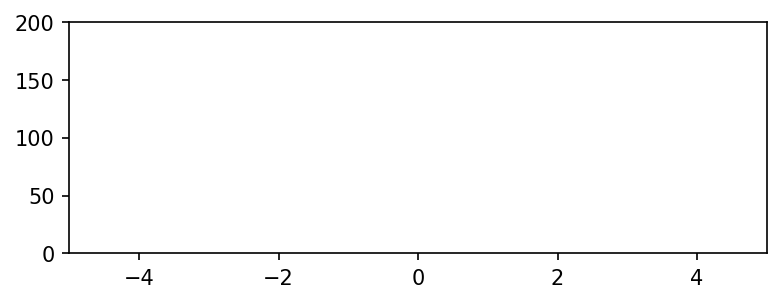

In [19]:
import jax
import optax
import celluloid

opt = optax.adam(4e-2)
params = 0.0
state = opt.init(params)
target = 3.0

fig, ax = plt.subplots()

cam = celluloid.Camera(fig)

for i in range(100):
    lvalue, g = jax.value_and_grad(loss)(params, target, inputs)
    updates, state = opt.update(g, state)
    params = optax.apply_updates(params, updates)
    if i % 5 == 0:
        print(f"delta: {params:.3g}, loss: {lvalue:.3g}")

        hard_hist = np.histogram(params + inputs, bins=bins)[0]
        hard_mean = np.sum(ctrs * hard_hist / len(inputs))
        ax.step(ctrs, hard_hist, where="mid", color="maroon")
        ax.set_xlim(-5, 5)
        ax.set_ylim(0, 200)
        ax.vlines(hard_mean, 0, 200, colors="maroon")
        ax.vlines(target, 0, 200, colors="k")
        cam.snap()
ani = cam.animate()
from IPython.display import HTML
HTML(ani.to_html5_video())